# pytrunc demo notebook

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import numpy as np
from scipy.integrate import simpson, trapezoid
from pytrunc.phase import calc_moments
from pytrunc.truncation import delta_m_phase_approx, gt_phase_approx
from pytrunc.utils import integrate_lobatto, quadrature_lobatto

import matplotlib.pyplot as plt
import xarray as xr

## Compute the polarized truncated phase matrix

### Get realistic water cloud phase function from mie calculation

wav=498.6099853515625 nm ; reff=8.0 um
2.0005251045322687


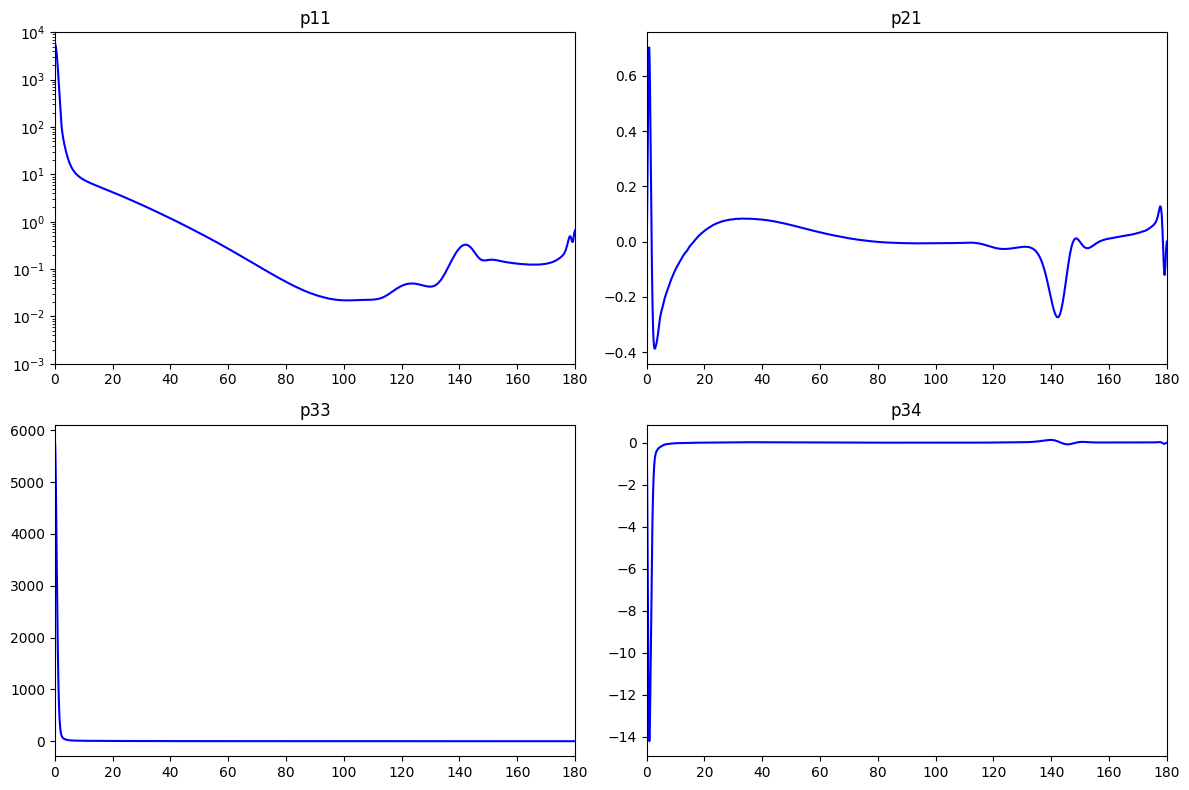

In [2]:
# wc available in smartg auxdata: https://github.com/hygeos/smartg
# Follow smartg README to download auxdata, 
# then create environemnt variable 'SMARTG_DIR_AUXDATA' where auxdata have been downloaded
wc_path = Path(os.environ['SMARTG_DIR_AUXDATA']) / Path('clouds/wc_sol.nc')
ds = xr.open_dataset(wc_path)
# in the paper (Iwabuchi et al. 2009) wl = 500 nm and reff = 8 um
iwav = 49 # iwabuchi
ireff = 3 # iwabuchi
print(f"wav={ds.wav.values[iwav]} nm ; reff={ds.reff.values[ireff]} um")
theta = ds['theta'].values
pha_ex = ds["phase"][ireff,iwav,:,:].values

method = 'lobatto'
# method = 'trapezoid'
# method = 'simpson' # use pair number for theta

INTEGRATORS = {
    "simpson": simpson,
    "trapezoid": trapezoid,
    "lobatto": integrate_lobatto
    }
integrate_m = INTEGRATORS[method]

# theta = np.linspace(0., 180., 18001)
# pha_ex = np.interp(theta, ds.theta.values, pha_ex)

# theta, _ = quadrature_lobatto(0., 180., 7201)
# pha_ex = np.interp(theta, ds.theta.values, pha_ex)

mu = np.cos(np.deg2rad(theta))
idmu = np.argsort(mu)


# renormalize depending on the chosen integration method
if method == 'lobatto':
    sin_th = np.sin(np.deg2rad(theta))
    pha_ex = (2. * pha_ex) / integrate_m(pha_ex[0,:]*sin_th, np.deg2rad(theta))
else:
    pha_ex = (2. * pha_ex) / integrate_m(pha_ex[0,idmu], mu[idmu])
print(trapezoid(pha_ex[0,:][idmu], mu[idmu]))



fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.ravel()
axs[0].plot(theta, pha_ex[0,:], 'b-', label='p11 exact')
axs[0].set_yscale('log')
axs[0].set_ylim(1e-3, 1e4)
axs[0].set_xlim(0, 180)
axs[0].set_title('p11')
axs[1].plot(theta, pha_ex[1,:], 'b-', label='p21 exact')
axs[1].set_xlim(0, 180)
axs[1].set_title('p21')
axs[2].plot(theta, pha_ex[2,:], 'b-', label='p33 exact')
axs[2].set_xlim(0, 180)
axs[2].set_title('p33')
axs[3].plot(theta, pha_ex[3,:], 'b-', label='p34 exact')
axs[3].set_xlim(0, 180)
axs[3].set_title('p34')
plt.tight_layout()
plt.show()

### Compute the polarized truncated phase matrix using the GT method
- Iwabuchi 2009

f= 0.4331414968663314


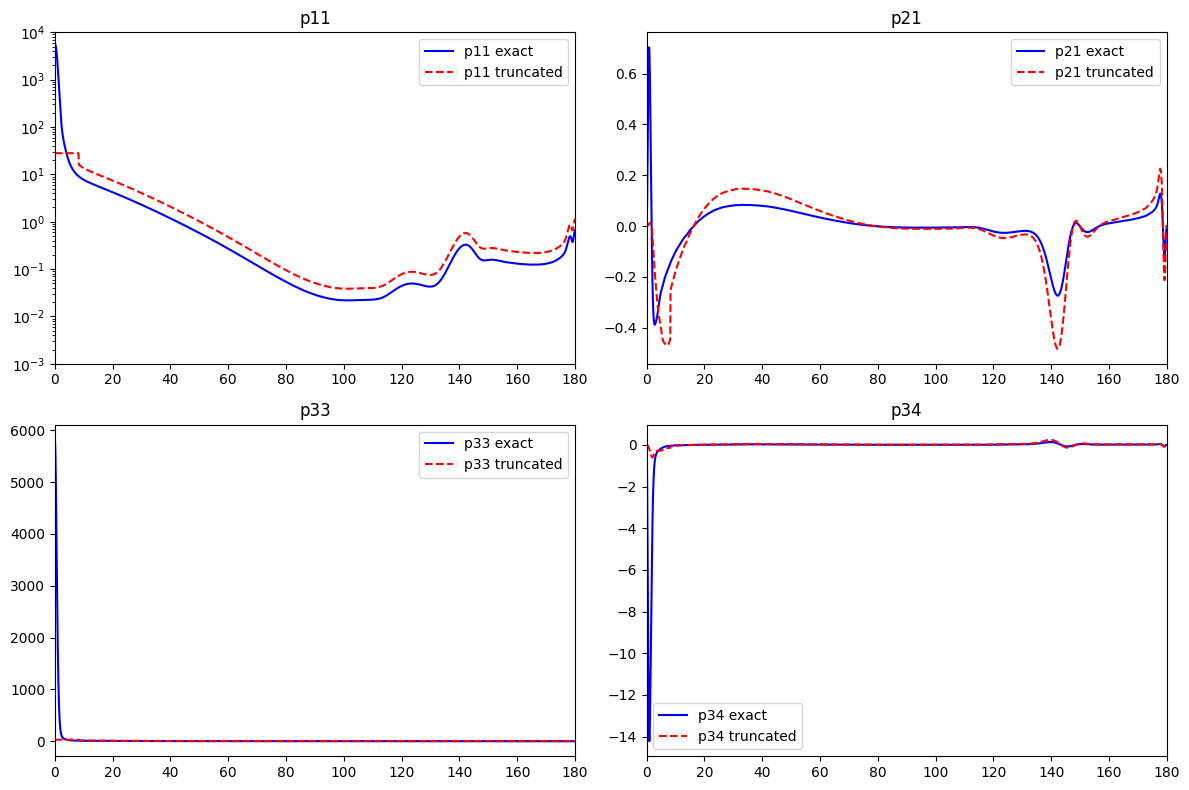

In [3]:
# Get the f value equal to chi_20
m_max = 20
chi = calc_moments(pha_ex[0,:], theta, m_max=m_max, normalize=True)
f = chi[m_max]
print('f=', f)

f11_approx, _, f11_tr = gt_phase_approx(pha_ex[0,:], theta, f, method=method, 
                                        phase_moments_1=chi[1], th_tol=20.)

# Eq.5 in Waquet and Herman, 2019
pha_tr = np.zeros_like(pha_ex)
pha_tr[0,:] = f11_tr
beta = (pha_tr[0,:] / pha_ex[0,:])
for i in range(1, pha_ex.shape[0]):
    pha_tr[i,:] = pha_ex[i,:] * beta

fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.ravel()
axs[0].plot(theta, pha_ex[0,:], 'b-', label='p11 exact')
axs[0].plot(theta, pha_tr[0,:], 'r--', label='p11 truncated')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_ylim(1e-3, 1e4)
axs[0].set_xlim(0, 180)
axs[0].set_title('p11')
axs[1].plot(theta, pha_ex[1,:], 'b-', label='p21 exact')
axs[1].plot(theta, pha_tr[1,:], 'r--', label='p21 truncated')
axs[1].legend()
axs[1].set_xlim(0, 180)
axs[1].set_title('p21')
axs[2].plot(theta, pha_ex[2,:], 'b-', label='p33 exact')
axs[2].plot(theta, pha_tr[2,:], 'r--', label='p33 truncated')
axs[2].legend()
# axs[2].set_yscale('log')
# axs[2].set_ylim(-1., 1)
axs[2].set_xlim(0, 180)
axs[2].set_title('p33')
axs[3].plot(theta, pha_ex[3,:], 'b-', label='p34 exact')
axs[3].plot(theta, pha_tr[3,:], 'r--', label='p34 truncated')
axs[3].legend()
axs[3].set_xlim(0, 180)
axs[3].set_title('p34')
plt.tight_layout()
plt.show()

### Compute the polarized truncated phase matrix using the delta-M method
- Wiscombe et al. 1997

f= 0.4331414968663314


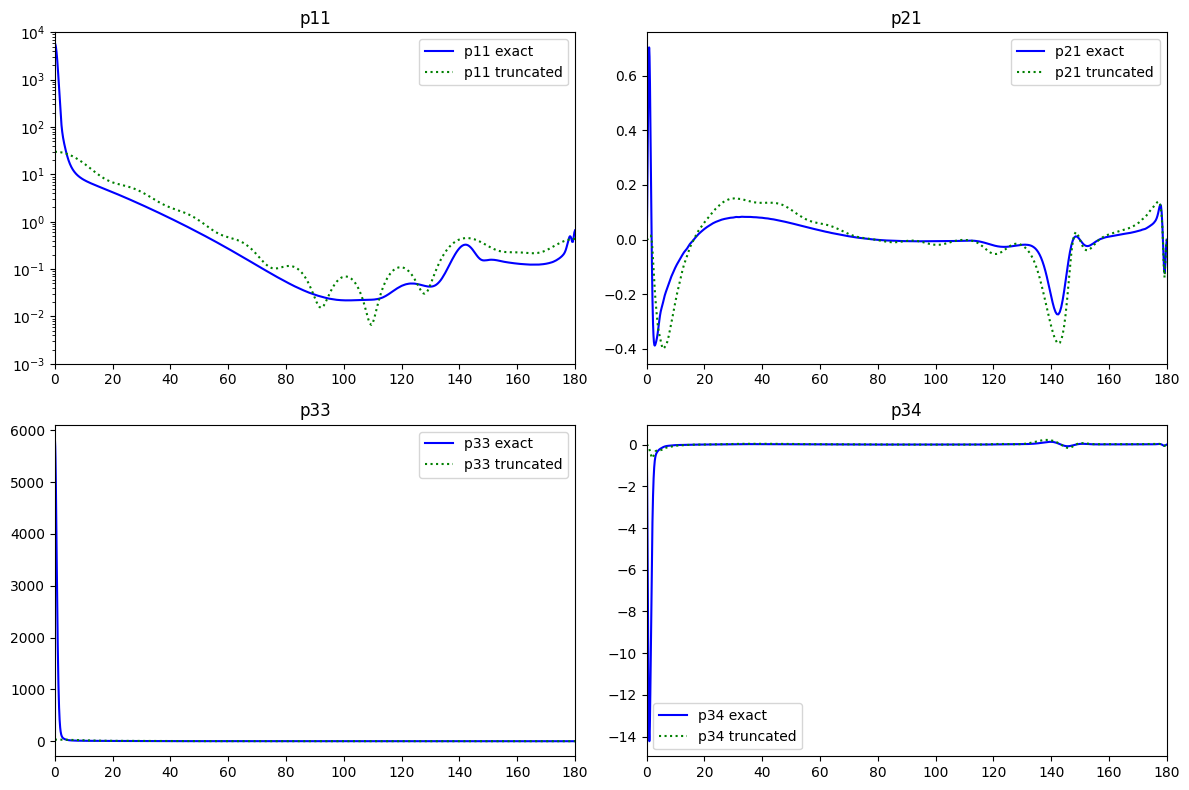

In [4]:
# Get the f value equal to chi_20
m_max = 20
f11_approx, f, f11_tr, _ = delta_m_phase_approx(pha_ex[0,:], theta, m_max, method=method)
f = chi[m_max]
print('f=', f)

# Eq.5 in Waquet and Herman, 2019
pha_tr = np.zeros_like(pha_ex)
pha_tr[0,:] = f11_tr
beta = (pha_tr[0,:] / pha_ex[0,:])
for i in range(1, pha_ex.shape[0]):
    pha_tr[i,:] = pha_ex[i,:] * beta

fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.ravel()
axs[0].plot(theta, pha_ex[0,:], 'b-', label='p11 exact')
axs[0].plot(theta, pha_tr[0,:], 'g:', label='p11 truncated')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_ylim(1e-3, 1e4)
axs[0].set_xlim(0, 180)
axs[0].set_title('p11')
axs[1].plot(theta, pha_ex[1,:], 'b-', label='p21 exact')
axs[1].plot(theta, pha_tr[1,:], 'g:', label='p21 truncated')
axs[1].legend()
axs[1].set_xlim(0, 180)
axs[1].set_title('p21')
axs[2].plot(theta, pha_ex[2,:], 'b-', label='p33 exact')
axs[2].plot(theta, pha_tr[2,:], 'g:', label='p33 truncated')
axs[2].legend()
# axs[2].set_yscale('log')
# axs[2].set_ylim(-1., 1)
axs[2].set_xlim(0, 180)
axs[2].set_title('p33')
axs[3].plot(theta, pha_ex[3,:], 'b-', label='p34 exact')
axs[3].plot(theta, pha_tr[3,:], 'g:', label='p34 truncated')
axs[3].legend()
axs[3].set_xlim(0, 180)
axs[3].set_title('p34')
plt.tight_layout()
plt.show()